## classification of emotion from text using Bert pre-trained model



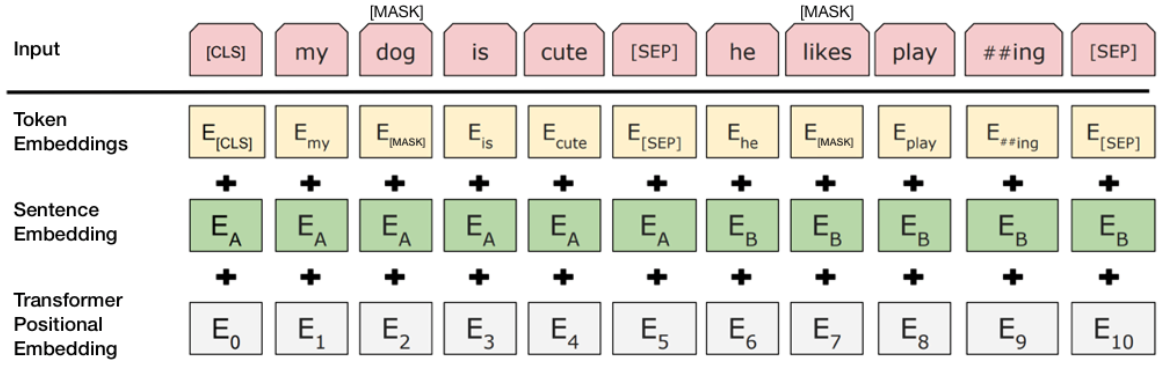

## Problem statement:

In the era of a customer-focused industry, companies are coming up with new ways to understand their consumers. Detecting emotions accurately from the reviews, chats, tweets, blogs, posts, etc. is one such method without explicitly asking the customers. With the advent of new algorithms and increasing computing power, Natural Language Processing (NLP) has enabled us to detect emotions from written text & take action accordingly.

Here, We have to detect the emotions of customers based on the tweets by using state-of-the-art architectures to solve the probelem and predict accurately.

   ## Annotations of different emotions:
   
   ## Joy : 0
   ## Fear : 1 
   ## Anger : 2 
   ## Sadness : 3 
   ## Disgust : 4
   ## Shame : 5

## Table of contents
 
1. ## Importing and installing required libraries
2. ## Text preprocessing
3. ## Loading the model (bert)
4. ## Model fitting and evaluation
5. ## Prediction part
6. ## Prediction on custom text

# 1. Importing and Installing required libraries

In [2]:
!pip install text_hammer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import text_hammer as th
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
from sklearn.model_selection import train_test_split
# from transformers import AutoTokenizer,TFBertModel
# from transformers import BertTokenizer, TFBertModel, BertConfig,TFDistilBertModel,DistilBertTokenizer,DistilBertConfig
import shutil
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False # if autocompletion doesnot work in kaggle notebook | hit tab

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 69.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 68.5 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer,TFBertModel
from transformers import BertTokenizer, TFBertModel, BertConfig,TFDistilBertModel,DistilBertTokenizer,DistilBertConfig


In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df_full = pd.read_csv('/content/the_data.csv')
df_full

,text,label
0,"During the period of falling in love, each tim...",0
1,When I was involved in a traffic accident.,1
2,When I was driving home after several days of...,2
3,When I lost the person who meant the most to me.,3
4,The time I knocked a deer down - the sight of ...,4
...,...,...
7475,Two years back someone invited me to be the tu...,2
7476,I had taken the responsibility to do something...,3
7477,I was at home and I heard a loud sound of spit...,4
7478,I did not do the homework that the teacher had...,5


# 2. Text preprocessing 

In [ ]:
def text_preprocessing(df,col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
    df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
 
    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
 
    return(df)

In [ ]:
df_cleaned = text_preprocessing(df_full,'text')

  0%|          | 0/7480 [00:00<?, ?it/s]

  0%|          | 0/7480 [00:00<?, ?it/s]

  0%|          | 0/7480 [00:00<?, ?it/s]

  0%|          | 0/7480 [00:00<?, ?it/s]

  0%|          | 0/7480 [00:00<?, ?it/s]

  0%|          | 0/7480 [00:00<?, ?it/s]

In [ ]:
df_cleaned = df_cleaned.copy()

In [ ]:
df_cleaned['num_words'] = df_cleaned['text'].apply(lambda x:len(x.split()))

In [ ]:
# changing the data type to the category to encode into codes 
df_cleaned['label'] = df_cleaned['label'].astype('category')

In [ ]:
df_cleaned['label']

0       0
1       1
2       2
3       3
4       4
       ..
7475    2
7476    3
7477    4
7478    5
7479    5
Name: label, Length: 7480, dtype: category
Categories (6, int64): [0, 1, 2, 3, 4, 5]

In [ ]:
df_cleaned['label'].cat.codes

0       0
1       1
2       2
3       3
4       4
       ..
7475    2
7476    3
7477    4
7478    5
7479    5
Length: 7480, dtype: int8

In [ ]:
encoded_dict  = {'joy':0,'fear':1, 'anger':2, 'sadness':3, 'disgust':4, 'shame':5}

In [ ]:
df_cleaned.num_words.max()

179

In [ ]:
data_train,data_test = train_test_split(df_cleaned, test_size = 0.3, random_state = 42, stratify = df_cleaned['label'])

In [ ]:
data_train.shape

(5236, 3)

In [ ]:
data_test.shape

(2244, 3)

In [ ]:
to_categorical(data_train['label'])

array([[0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

# 3. Load the model (bert)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


# **About bert**
* Bert is a model that pre-trained on a large corpus of text, such as Wikipedia or BookCorpus, using an unsupervised learning method called Masked Language Modeling.
* On this model we only used the tokenizer form bert
  * A normal tokenizer sweech words in to meaningless numbers 
  * Bert tokenizer sweach words that have the same meaning in to numbers that relatively close to each other
  * This gives our model a better chance of predicting the emotions from sentences we haven't yet encountered.

https://huggingface.co/bert-base-cased

In [ ]:
# for saving model locally and we can load it later on 
tokenizer.save_pretrained('bert-tokenizer')
bert.save_pretrained('bert-model')

In [ ]:
shutil.make_archive('bert-tokenizer', 'zip', 'bert-tokenizer')
shutil.make_archive('bert-model','zip','bert-model')

'/content/bert-model.zip'

In [ ]:
tokenizer('I will be kaggle grandmaster')

{'input_ids': [101, 146, 1209, 1129, 24181, 25186, 5372, 6532, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
# Tokenize the input (takes some time) 
# here tokenizer using from bert-base-cased
x_train = tokenizer(
    text=data_train['text'].tolist(),
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)


x_test = tokenizer(
    text=data_test['text'].tolist(),
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [ ]:
x_test['input_ids']

<tf.Tensor: shape=(2244, 70), dtype=int32, numpy=
array([[ 101, 1103, 3945, ...,    0,    0,    0],
       [ 101,  170, 1374, ...,    0,    0,    0],
       [ 101,  178, 3668, ...,    0,    0,    0],
       ...,
       [ 101,  170, 2370, ...,    0,    0,    0],
       [ 101, 1165, 1800, ...,    0,    0,    0],
       [ 101, 1165, 1139, ...,    0,    0,    0]], dtype=int32)>

In [ ]:
max_len = 70
 
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

embeddings = bert(input_ids,attention_mask = input_mask)[0] #(0 is the last hidden states,1 means pooler_output)
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)

y = Dense(6,activation = 'sigmoid')(out)
    
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

In [ ]:
optimizer = tf.keras.optimizers.legacy.Adam(
    learning_rate=5e-05, # this learning rate is for bert model , taken from huggingface website 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss =CategoricalCrossentropy(from_logits = True)
metric = CategoricalAccuracy('balanced_accuracy'),
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 70)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 70)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 70,                                            

In [ ]:
tf.config.experimental_run_functions_eagerly(True)
tf.config.run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


# 4. Model fitting and then evaluation

In [ ]:
train_history = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = to_categorical(data_train['label']),
    validation_data = (
    {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, to_categorical(data_test['label'])
    ),
  epochs=4,
    batch_size=36
)

Epoch 1/4


  1/146 [..............................] - ETA: 1:57:58 - loss: 1.7881 - balanced_accuracy: 0.1944

  2/146 [..............................] - ETA: 1:43:24 - loss: 1.8131 - balanced_accuracy: 0.1944

  3/146 [..............................] - ETA: 1:32:05 - loss: 1.7753 - balanced_accuracy: 0.2037

  4/146 [..............................] - ETA: 1:28:13 - loss: 1.7592 - balanced_accuracy: 0.2292

  5/146 [>.............................] - ETA: 1:24:58 - loss: 1.7614 - balanced_accuracy: 0.2278

  6/146 [>.............................] - ETA: 1:24:23 - loss: 1.7525 - balanced_accuracy: 0.2315

  7/146 [>.............................] - ETA: 1:22:16 - loss: 1.7448 - balanced_accuracy: 0.2302

  8/146 [>.............................] - ETA: 1:20:52 - loss: 1.7500 - balanced_accuracy: 0.2257

  9/146 [>.............................] - ETA: 1:19:52 - loss: 1.7551 - balanced_accuracy: 0.2222

 10/146 [=>............................] - ETA: 1:18:28 - loss: 1.7475 - balanced_accuracy: 0.2389

 11/146 [=>............................] - ETA: 1:17:14 - loss: 1.7487 - balanced_accuracy: 0.2374

 12/146 [=>............................] - ETA: 1:16:29 - loss: 1.7590 - balanced_accuracy: 0.2269

 13/146 [=>............................] - ETA: 1:16:37 - loss: 1.7583 - balanced_accuracy: 0.2286

 14/146 [=>............................] - ETA: 1:15:45 - loss: 1.7609 - balanced_accuracy: 0.2262

 15/146 [==>...........................] - ETA: 1:15:33 - loss: 1.7605 - balanced_accuracy: 0.2278

 16/146 [==>...........................] - ETA: 1:14:34 - loss: 1.7532 - balanced_accuracy: 0.2344

 17/146 [==>...........................] - ETA: 1:13:42 - loss: 1.7480 - balanced_accuracy: 0.2353

 18/146 [==>...........................] - ETA: 1:12:53 - loss: 1.7396 - balanced_accuracy: 0.2407

 19/146 [==>...........................] - ETA: 1:12:04 - loss: 1.7285 - balanced_accuracy: 0.2529

 20/146 [===>..........................] - ETA: 1:11:24 - loss: 1.7287 - balanced_accuracy: 0.2528

 21/146 [===>..........................] - ETA: 1:10:36 - loss: 1.7239 - balanced_accuracy: 0.2566

 22/146 [===>..........................] - ETA: 1:10:08 - loss: 1.7252 - balanced_accuracy: 0.2588

 23/146 [===>..........................] - ETA: 1:09:24 - loss: 1.7220 - balanced_accuracy: 0.2609

 24/146 [===>..........................] - ETA: 1:08:39 - loss: 1.7161 - balanced_accuracy: 0.2674

 25/146 [====>.........................] - ETA: 1:08:06 - loss: 1.7104 - balanced_accuracy: 0.2700

 26/146 [====>.........................] - ETA: 1:07:28 - loss: 1.7001 - balanced_accuracy: 0.2756

 27/146 [====>.........................] - ETA: 1:06:50 - loss: 1.6983 - balanced_accuracy: 0.2757

 28/146 [====>.........................] - ETA: 1:06:17 - loss: 1.6968 - balanced_accuracy: 0.2778

 29/146 [====>.........................] - ETA: 1:05:39 - loss: 1.6954 - balanced_accuracy: 0.2797

 30/146 [=====>........................] - ETA: 1:04:57 - loss: 1.6911 - balanced_accuracy: 0.2787

 31/146 [=====>........................] - ETA: 1:04:15 - loss: 1.6847 - balanced_accuracy: 0.2849

 32/146 [=====>........................] - ETA: 1:03:33 - loss: 1.6794 - balanced_accuracy: 0.2899

 33/146 [=====>........................] - ETA: 1:02:57 - loss: 1.6756 - balanced_accuracy: 0.2946

 34/146 [=====>........................] - ETA: 1:02:30 - loss: 1.6712 - balanced_accuracy: 0.2958

 35/146 [======>.......................] - ETA: 1:01:53 - loss: 1.6727 - balanced_accuracy: 0.2968

 36/146 [======>.......................] - ETA: 1:01:25 - loss: 1.6621 - balanced_accuracy: 0.3040

 37/146 [======>.......................] - ETA: 1:00:49 - loss: 1.6535 - balanced_accuracy: 0.3078

 38/146 [======>.......................] - ETA: 1:00:10 - loss: 1.6490 - balanced_accuracy: 0.3107

 39/146 [=======>......................] - ETA: 59:36 - loss: 1.6411 - balanced_accuracy: 0.3148  

 40/146 [=======>......................] - ETA: 58:59 - loss: 1.6351 - balanced_accuracy: 0.3187

 41/146 [=======>......................] - ETA: 58:21 - loss: 1.6238 - balanced_accuracy: 0.3266

 42/146 [=======>......................] - ETA: 57:45 - loss: 1.6205 - balanced_accuracy: 0.3294

 43/146 [=======>......................] - ETA: 57:14 - loss: 1.6161 - balanced_accuracy: 0.3307

 44/146 [========>.....................] - ETA: 56:41 - loss: 1.6135 - balanced_accuracy: 0.3333

 45/146 [========>.....................] - ETA: 56:03 - loss: 1.6064 - balanced_accuracy: 0.3377

 46/146 [========>.....................] - ETA: 55:29 - loss: 1.6091 - balanced_accuracy: 0.3370

 47/146 [========>.....................] - ETA: 54:52 - loss: 1.6005 - balanced_accuracy: 0.3392

 48/146 [========>.....................] - ETA: 54:15 - loss: 1.5963 - balanced_accuracy: 0.3426

 49/146 [=========>....................] - ETA: 53:39 - loss: 1.5909 - balanced_accuracy: 0.3464

 50/146 [=========>....................] - ETA: 53:04 - loss: 1.5887 - balanced_accuracy: 0.3467

 51/146 [=========>....................] - ETA: 52:29 - loss: 1.5832 - balanced_accuracy: 0.3497

 52/146 [=========>....................] - ETA: 51:54 - loss: 1.5779 - balanced_accuracy: 0.3531

 53/146 [=========>....................] - ETA: 51:22 - loss: 1.5749 - balanced_accuracy: 0.3538

 54/146 [==========>...................] - ETA: 50:47 - loss: 1.5680 - balanced_accuracy: 0.3570

 55/146 [==========>...................] - ETA: 50:14 - loss: 1.5622 - balanced_accuracy: 0.3591

 56/146 [==========>...................] - ETA: 49:38 - loss: 1.5571 - balanced_accuracy: 0.3621

 57/146 [==========>...................] - ETA: 49:04 - loss: 1.5549 - balanced_accuracy: 0.3660

 58/146 [==========>...................] - ETA: 48:31 - loss: 1.5486 - balanced_accuracy: 0.3688

 59/146 [===========>..................] - ETA: 47:57 - loss: 1.5389 - balanced_accuracy: 0.3752

 60/146 [===========>..................] - ETA: 47:22 - loss: 1.5355 - balanced_accuracy: 0.3773

 61/146 [===========>..................] - ETA: 46:49 - loss: 1.5300 - balanced_accuracy: 0.3811

 62/146 [===========>..................] - ETA: 46:15 - loss: 1.5227 - balanced_accuracy: 0.3844

 63/146 [===========>..................] - ETA: 45:40 - loss: 1.5186 - balanced_accuracy: 0.3862

 64/146 [============>.................] - ETA: 45:05 - loss: 1.5121 - balanced_accuracy: 0.3893

 65/146 [============>.................] - ETA: 44:31 - loss: 1.5084 - balanced_accuracy: 0.3923

 66/146 [============>.................] - ETA: 43:57 - loss: 1.5057 - balanced_accuracy: 0.3935

 67/146 [============>.................] - ETA: 43:23 - loss: 1.4966 - balanced_accuracy: 0.3976

 68/146 [============>.................] - ETA: 42:49 - loss: 1.4904 - balanced_accuracy: 0.4011

 69/146 [=============>................] - ETA: 42:15 - loss: 1.4874 - balanced_accuracy: 0.4022

 70/146 [=============>................] - ETA: 41:42 - loss: 1.4821 - balanced_accuracy: 0.4048

 71/146 [=============>................] - ETA: 41:08 - loss: 1.4776 - balanced_accuracy: 0.4069

 72/146 [=============>................] - ETA: 40:35 - loss: 1.4700 - balanced_accuracy: 0.4105

 73/146 [==============>...............] - ETA: 40:02 - loss: 1.4658 - balanced_accuracy: 0.4144

 74/146 [==============>...............] - ETA: 39:28 - loss: 1.4582 - balanced_accuracy: 0.4178

 75/146 [==============>...............] - ETA: 38:54 - loss: 1.4570 - balanced_accuracy: 0.4189

 76/146 [==============>...............] - ETA: 38:21 - loss: 1.4498 - balanced_accuracy: 0.4218

 77/146 [==============>...............] - ETA: 37:49 - loss: 1.4443 - balanced_accuracy: 0.4250

 78/146 [===============>..............] - ETA: 37:16 - loss: 1.4372 - balanced_accuracy: 0.4281

 79/146 [===============>..............] - ETA: 36:42 - loss: 1.4349 - balanced_accuracy: 0.4272

 80/146 [===============>..............] - ETA: 36:10 - loss: 1.4314 - balanced_accuracy: 0.4292

 81/146 [===============>..............] - ETA: 35:36 - loss: 1.4252 - balanced_accuracy: 0.4321

 82/146 [===============>..............] - ETA: 35:02 - loss: 1.4219 - balanced_accuracy: 0.4343

 83/146 [================>.............] - ETA: 34:29 - loss: 1.4181 - balanced_accuracy: 0.4367

 84/146 [================>.............] - ETA: 33:56 - loss: 1.4114 - balanced_accuracy: 0.4405

 85/146 [================>.............] - ETA: 33:22 - loss: 1.4060 - balanced_accuracy: 0.4438

 86/146 [================>.............] - ETA: 32:49 - loss: 1.4043 - balanced_accuracy: 0.4448

 87/146 [================>.............] - ETA: 32:16 - loss: 1.4000 - balanced_accuracy: 0.4476

 88/146 [=================>............] - ETA: 31:43 - loss: 1.3963 - balanced_accuracy: 0.4501

 89/146 [=================>............] - ETA: 31:09 - loss: 1.3943 - balanced_accuracy: 0.4513

 90/146 [=================>............] - ETA: 30:36 - loss: 1.3872 - balanced_accuracy: 0.4537

 91/146 [=================>............] - ETA: 30:03 - loss: 1.3818 - balanced_accuracy: 0.4567

 92/146 [=================>............] - ETA: 29:30 - loss: 1.3759 - balanced_accuracy: 0.4589

 93/146 [==================>...........] - ETA: 28:57 - loss: 1.3708 - balanced_accuracy: 0.4621

 94/146 [==================>...........] - ETA: 28:24 - loss: 1.3649 - balanced_accuracy: 0.4648

 95/146 [==================>...........] - ETA: 27:51 - loss: 1.3605 - balanced_accuracy: 0.4664

 96/146 [==================>...........] - ETA: 27:18 - loss: 1.3577 - balanced_accuracy: 0.4673

 97/146 [==================>...........] - ETA: 26:45 - loss: 1.3541 - balanced_accuracy: 0.4688

 98/146 [===================>..........] - ETA: 26:12 - loss: 1.3491 - balanced_accuracy: 0.4717

 99/146 [===================>..........] - ETA: 25:39 - loss: 1.3435 - balanced_accuracy: 0.4745

100/146 [===================>..........] - ETA: 25:06 - loss: 1.3403 - balanced_accuracy: 0.4761

101/146 [===================>..........] - ETA: 24:33 - loss: 1.3348 - balanced_accuracy: 0.4783

102/146 [===================>..........] - ETA: 24:00 - loss: 1.3341 - balanced_accuracy: 0.4785

103/146 [====================>.........] - ETA: 23:27 - loss: 1.3300 - balanced_accuracy: 0.4806

104/146 [====================>.........] - ETA: 22:55 - loss: 1.3236 - balanced_accuracy: 0.4840

105/146 [====================>.........] - ETA: 22:21 - loss: 1.3216 - balanced_accuracy: 0.4847

106/146 [====================>.........] - ETA: 21:49 - loss: 1.3186 - balanced_accuracy: 0.4866

107/146 [====================>.........] - ETA: 21:16 - loss: 1.3139 - balanced_accuracy: 0.4891

108/146 [=====================>........] - ETA: 20:43 - loss: 1.3104 - balanced_accuracy: 0.4907

109/146 [=====================>........] - ETA: 20:10 - loss: 1.3078 - balanced_accuracy: 0.4918

110/146 [=====================>........] - ETA: 19:38 - loss: 1.3061 - balanced_accuracy: 0.4927

111/146 [=====================>........] - ETA: 19:05 - loss: 1.3055 - balanced_accuracy: 0.4937

112/146 [======================>.......] - ETA: 18:32 - loss: 1.3042 - balanced_accuracy: 0.4950

113/146 [======================>.......] - ETA: 17:59 - loss: 1.3011 - balanced_accuracy: 0.4966

114/146 [======================>.......] - ETA: 17:26 - loss: 1.2963 - balanced_accuracy: 0.4985

115/146 [======================>.......] - ETA: 16:53 - loss: 1.2935 - balanced_accuracy: 0.5000

116/146 [======================>.......] - ETA: 16:20 - loss: 1.2920 - balanced_accuracy: 0.5005

117/146 [=======================>......] - ETA: 15:47 - loss: 1.2887 - balanced_accuracy: 0.5019

118/146 [=======================>......] - ETA: 15:14 - loss: 1.2857 - balanced_accuracy: 0.5040

119/146 [=======================>......] - ETA: 14:41 - loss: 1.2830 - balanced_accuracy: 0.5058

120/146 [=======================>......] - ETA: 14:09 - loss: 1.2782 - balanced_accuracy: 0.5079

121/146 [=======================>......] - ETA: 13:36 - loss: 1.2748 - balanced_accuracy: 0.5096

122/146 [========================>.....] - ETA: 13:03 - loss: 1.2733 - balanced_accuracy: 0.5102

123/146 [========================>.....] - ETA: 12:31 - loss: 1.2712 - balanced_accuracy: 0.5117

124/146 [========================>.....] - ETA: 11:58 - loss: 1.2686 - balanced_accuracy: 0.5137

125/146 [========================>.....] - ETA: 11:25 - loss: 1.2648 - balanced_accuracy: 0.5153

126/146 [========================>.....] - ETA: 10:53 - loss: 1.2610 - balanced_accuracy: 0.5170

127/146 [=========================>....] - ETA: 10:20 - loss: 1.2576 - balanced_accuracy: 0.5182

128/146 [=========================>....] - ETA: 9:48 - loss: 1.2545 - balanced_accuracy: 0.5197 

129/146 [=========================>....] - ETA: 9:15 - loss: 1.2511 - balanced_accuracy: 0.5215

130/146 [=========================>....] - ETA: 8:42 - loss: 1.2485 - balanced_accuracy: 0.5229

131/146 [=========================>....] - ETA: 8:09 - loss: 1.2461 - balanced_accuracy: 0.5242

132/146 [==========================>...] - ETA: 7:37 - loss: 1.2438 - balanced_accuracy: 0.5250

133/146 [==========================>...] - ETA: 7:04 - loss: 1.2406 - balanced_accuracy: 0.5267

134/146 [==========================>...] - ETA: 6:31 - loss: 1.2390 - balanced_accuracy: 0.5282

135/146 [==========================>...] - ETA: 5:59 - loss: 1.2378 - balanced_accuracy: 0.5284

136/146 [==========================>...] - ETA: 5:26 - loss: 1.2347 - balanced_accuracy: 0.5294

137/146 [===========================>..] - ETA: 4:53 - loss: 1.2305 - balanced_accuracy: 0.5314

138/146 [===========================>..] - ETA: 4:21 - loss: 1.2278 - balanced_accuracy: 0.5322

139/146 [===========================>..] - ETA: 3:48 - loss: 1.2258 - balanced_accuracy: 0.5330

140/146 [===========================>..] - ETA: 3:15 - loss: 1.2241 - balanced_accuracy: 0.5341

141/146 [===========================>..] - ETA: 2:43 - loss: 1.2218 - balanced_accuracy: 0.5351

142/146 [============================>.] - ETA: 2:10 - loss: 1.2162 - balanced_accuracy: 0.5376

143/146 [============================>.] - ETA: 1:37 - loss: 1.2120 - balanced_accuracy: 0.5396

144/146 [============================>.] - ETA: 1:05 - loss: 1.2093 - balanced_accuracy: 0.5407

145/146 [============================>.] - ETA: 32s - loss: 1.2051 - balanced_accuracy: 0.5425 

146/146 [==============================] - 5385s 37s/step - loss: 1.2046 - balanced_accuracy: 0.5424 - val_loss: 0.8886 - val_balanced_accuracy: 0.6881
Epoch 2/4


  1/146 [..............................] - ETA: 1:24:26 - loss: 0.8760 - balanced_accuracy: 0.6667

  2/146 [..............................] - ETA: 1:18:12 - loss: 0.8688 - balanced_accuracy: 0.6806

  3/146 [..............................] - ETA: 1:16:30 - loss: 0.7690 - balanced_accuracy: 0.7315

  4/146 [..............................] - ETA: 1:14:53 - loss: 0.7332 - balanced_accuracy: 0.7222

  5/146 [>.............................] - ETA: 1:14:13 - loss: 0.7014 - balanced_accuracy: 0.7389

  6/146 [>.............................] - ETA: 1:13:54 - loss: 0.6930 - balanced_accuracy: 0.7500

  7/146 [>.............................] - ETA: 1:13:52 - loss: 0.7075 - balanced_accuracy: 0.7460

  8/146 [>.............................] - ETA: 1:13:13 - loss: 0.7217 - balanced_accuracy: 0.7396

  9/146 [>.............................] - ETA: 1:12:31 - loss: 0.7095 - balanced_accuracy: 0.7438

 10/146 [=>............................] - ETA: 1:11:49 - loss: 0.7018 - balanced_accuracy: 0.7444

 11/146 [=>............................] - ETA: 1:11:13 - loss: 0.6866 - balanced_accuracy: 0.7500

 12/146 [=>............................] - ETA: 1:10:45 - loss: 0.6911 - balanced_accuracy: 0.7477

 13/146 [=>............................] - ETA: 1:10:01 - loss: 0.6856 - balanced_accuracy: 0.7521

 14/146 [=>............................] - ETA: 1:09:38 - loss: 0.6814 - balanced_accuracy: 0.7480

 15/146 [==>...........................] - ETA: 1:09:05 - loss: 0.6772 - balanced_accuracy: 0.7463

 16/146 [==>...........................] - ETA: 1:08:36 - loss: 0.6753 - balanced_accuracy: 0.7500

 17/146 [==>...........................] - ETA: 1:08:03 - loss: 0.6794 - balanced_accuracy: 0.7533

 18/146 [==>...........................] - ETA: 1:07:30 - loss: 0.6877 - balanced_accuracy: 0.7469

 19/146 [==>...........................] - ETA: 1:06:56 - loss: 0.6932 - balanced_accuracy: 0.7456

 20/146 [===>..........................] - ETA: 1:06:31 - loss: 0.6878 - balanced_accuracy: 0.7486

 21/146 [===>..........................] - ETA: 1:06:01 - loss: 0.6801 - balanced_accuracy: 0.7526

 22/146 [===>..........................] - ETA: 1:05:25 - loss: 0.6786 - balanced_accuracy: 0.7500

 23/146 [===>..........................] - ETA: 1:04:54 - loss: 0.6744 - balanced_accuracy: 0.7512

 24/146 [===>..........................] - ETA: 1:04:20 - loss: 0.6721 - balanced_accuracy: 0.7535

 25/146 [====>.........................] - ETA: 1:03:56 - loss: 0.6716 - balanced_accuracy: 0.7544

 26/146 [====>.........................] - ETA: 1:03:24 - loss: 0.6639 - balanced_accuracy: 0.7564

 27/146 [====>.........................] - ETA: 1:02:55 - loss: 0.6674 - balanced_accuracy: 0.7562

 28/146 [====>.........................] - ETA: 1:02:25 - loss: 0.6586 - balanced_accuracy: 0.7609

 29/146 [====>.........................] - ETA: 1:01:58 - loss: 0.6645 - balanced_accuracy: 0.7586

 30/146 [=====>........................] - ETA: 1:01:23 - loss: 0.6577 - balanced_accuracy: 0.7620

 31/146 [=====>........................] - ETA: 1:00:50 - loss: 0.6550 - balanced_accuracy: 0.7643

 32/146 [=====>........................] - ETA: 1:00:17 - loss: 0.6602 - balanced_accuracy: 0.7630

 33/146 [=====>........................] - ETA: 59:52 - loss: 0.6629 - balanced_accuracy: 0.7635  

 34/146 [=====>........................] - ETA: 59:21 - loss: 0.6571 - balanced_accuracy: 0.7663

 35/146 [======>.......................] - ETA: 58:50 - loss: 0.6559 - balanced_accuracy: 0.7659

 36/146 [======>.......................] - ETA: 58:18 - loss: 0.6458 - balanced_accuracy: 0.7716

 37/146 [======>.......................] - ETA: 57:47 - loss: 0.6526 - balanced_accuracy: 0.7703

 38/146 [======>.......................] - ETA: 57:19 - loss: 0.6498 - balanced_accuracy: 0.7719

 39/146 [=======>......................] - ETA: 56:45 - loss: 0.6434 - balanced_accuracy: 0.7756

 40/146 [=======>......................] - ETA: 56:11 - loss: 0.6455 - balanced_accuracy: 0.7750

 41/146 [=======>......................] - ETA: 55:39 - loss: 0.6494 - balanced_accuracy: 0.7730

 42/146 [=======>......................] - ETA: 55:07 - loss: 0.6542 - balanced_accuracy: 0.7725

 43/146 [=======>......................] - ETA: 54:34 - loss: 0.6643 - balanced_accuracy: 0.7674

 44/146 [========>.....................] - ETA: 54:01 - loss: 0.6607 - balanced_accuracy: 0.7689

 45/146 [========>.....................] - ETA: 53:29 - loss: 0.6561 - balanced_accuracy: 0.7704

 46/146 [========>.....................] - ETA: 53:00 - loss: 0.6601 - balanced_accuracy: 0.7669

 47/146 [========>.....................] - ETA: 52:26 - loss: 0.6590 - balanced_accuracy: 0.7671

 48/146 [========>.....................] - ETA: 51:54 - loss: 0.6579 - balanced_accuracy: 0.7691

 49/146 [=========>....................] - ETA: 51:24 - loss: 0.6595 - balanced_accuracy: 0.7676

 50/146 [=========>....................] - ETA: 50:55 - loss: 0.6627 - balanced_accuracy: 0.7650

 51/146 [=========>....................] - ETA: 50:23 - loss: 0.6650 - balanced_accuracy: 0.7636

 52/146 [=========>....................] - ETA: 49:52 - loss: 0.6648 - balanced_accuracy: 0.7634

 53/146 [=========>....................] - ETA: 49:20 - loss: 0.6610 - balanced_accuracy: 0.7647

 54/146 [==========>...................] - ETA: 48:50 - loss: 0.6621 - balanced_accuracy: 0.7649

 55/146 [==========>...................] - ETA: 48:17 - loss: 0.6605 - balanced_accuracy: 0.7662

 56/146 [==========>...................] - ETA: 47:46 - loss: 0.6641 - balanced_accuracy: 0.7669

 57/146 [==========>...................] - ETA: 47:16 - loss: 0.6641 - balanced_accuracy: 0.7666

 58/146 [==========>...................] - ETA: 46:45 - loss: 0.6612 - balanced_accuracy: 0.7672

 59/146 [===========>..................] - ETA: 46:13 - loss: 0.6578 - balanced_accuracy: 0.7693

 60/146 [===========>..................] - ETA: 45:41 - loss: 0.6582 - balanced_accuracy: 0.7685

 61/146 [===========>..................] - ETA: 45:08 - loss: 0.6551 - balanced_accuracy: 0.7700

 62/146 [===========>..................] - ETA: 44:37 - loss: 0.6561 - balanced_accuracy: 0.7697

 63/146 [===========>..................] - ETA: 44:04 - loss: 0.6554 - balanced_accuracy: 0.7694

 64/146 [============>.................] - ETA: 43:32 - loss: 0.6536 - balanced_accuracy: 0.7695

 65/146 [============>.................] - ETA: 43:00 - loss: 0.6526 - balanced_accuracy: 0.7705

 66/146 [============>.................] - ETA: 42:30 - loss: 0.6546 - balanced_accuracy: 0.7694

 67/146 [============>.................] - ETA: 41:57 - loss: 0.6554 - balanced_accuracy: 0.7695

 68/146 [============>.................] - ETA: 41:25 - loss: 0.6583 - balanced_accuracy: 0.7684

 69/146 [=============>................] - ETA: 40:53 - loss: 0.6604 - balanced_accuracy: 0.7665

 70/146 [=============>................] - ETA: 40:21 - loss: 0.6585 - balanced_accuracy: 0.7675

 71/146 [=============>................] - ETA: 39:50 - loss: 0.6554 - balanced_accuracy: 0.7688

 72/146 [=============>................] - ETA: 39:18 - loss: 0.6538 - balanced_accuracy: 0.7697

 73/146 [==============>...............] - ETA: 38:46 - loss: 0.6527 - balanced_accuracy: 0.7705

 74/146 [==============>...............] - ETA: 38:13 - loss: 0.6526 - balanced_accuracy: 0.7710

 75/146 [==============>...............] - ETA: 37:43 - loss: 0.6560 - balanced_accuracy: 0.7689

 76/146 [==============>...............] - ETA: 37:10 - loss: 0.6558 - balanced_accuracy: 0.7697

 77/146 [==============>...............] - ETA: 36:41 - loss: 0.6548 - balanced_accuracy: 0.7695

 78/146 [===============>..............] - ETA: 36:14 - loss: 0.6536 - balanced_accuracy: 0.7699

 79/146 [===============>..............] - ETA: 35:41 - loss: 0.6511 - balanced_accuracy: 0.7711

 80/146 [===============>..............] - ETA: 35:09 - loss: 0.6535 - balanced_accuracy: 0.7712

 81/146 [===============>..............] - ETA: 34:38 - loss: 0.6525 - balanced_accuracy: 0.7713

 82/146 [===============>..............] - ETA: 34:06 - loss: 0.6515 - balanced_accuracy: 0.7720

 83/146 [================>.............] - ETA: 33:33 - loss: 0.6528 - balanced_accuracy: 0.7721

 84/146 [================>.............] - ETA: 33:01 - loss: 0.6531 - balanced_accuracy: 0.7718

 85/146 [================>.............] - ETA: 32:29 - loss: 0.6514 - balanced_accuracy: 0.7729

 86/146 [================>.............] - ETA: 31:58 - loss: 0.6526 - balanced_accuracy: 0.7723

 87/146 [================>.............] - ETA: 31:26 - loss: 0.6525 - balanced_accuracy: 0.7720

 88/146 [=================>............] - ETA: 30:54 - loss: 0.6550 - balanced_accuracy: 0.7702

 89/146 [=================>............] - ETA: 30:23 - loss: 0.6556 - balanced_accuracy: 0.7703

 90/146 [=================>............] - ETA: 29:51 - loss: 0.6568 - balanced_accuracy: 0.7701

 91/146 [=================>............] - ETA: 29:19 - loss: 0.6590 - balanced_accuracy: 0.7692

 92/146 [=================>............] - ETA: 28:47 - loss: 0.6595 - balanced_accuracy: 0.7687

 93/146 [==================>...........] - ETA: 28:14 - loss: 0.6616 - balanced_accuracy: 0.7682

 94/146 [==================>...........] - ETA: 27:42 - loss: 0.6640 - balanced_accuracy: 0.7671

 95/146 [==================>...........] - ETA: 27:10 - loss: 0.6617 - balanced_accuracy: 0.7681

 96/146 [==================>...........] - ETA: 26:38 - loss: 0.6623 - balanced_accuracy: 0.7682

 97/146 [==================>...........] - ETA: 26:06 - loss: 0.6624 - balanced_accuracy: 0.7680

 98/146 [===================>..........] - ETA: 25:34 - loss: 0.6602 - balanced_accuracy: 0.7687

 99/146 [===================>..........] - ETA: 25:02 - loss: 0.6599 - balanced_accuracy: 0.7688

100/146 [===================>..........] - ETA: 24:30 - loss: 0.6615 - balanced_accuracy: 0.7678

101/146 [===================>..........] - ETA: 23:58 - loss: 0.6660 - balanced_accuracy: 0.7660

102/146 [===================>..........] - ETA: 23:26 - loss: 0.6661 - balanced_accuracy: 0.7661

103/146 [====================>.........] - ETA: 22:54 - loss: 0.6648 - balanced_accuracy: 0.7670

104/146 [====================>.........] - ETA: 22:22 - loss: 0.6630 - balanced_accuracy: 0.7674

105/146 [====================>.........] - ETA: 21:50 - loss: 0.6639 - balanced_accuracy: 0.7669

106/146 [====================>.........] - ETA: 21:18 - loss: 0.6622 - balanced_accuracy: 0.7676

107/146 [====================>.........] - ETA: 20:46 - loss: 0.6627 - balanced_accuracy: 0.7669

108/146 [=====================>........] - ETA: 20:13 - loss: 0.6618 - balanced_accuracy: 0.7677

109/146 [=====================>........] - ETA: 19:41 - loss: 0.6619 - balanced_accuracy: 0.7678

110/146 [=====================>........] - ETA: 19:09 - loss: 0.6611 - balanced_accuracy: 0.7684

111/146 [=====================>........] - ETA: 18:37 - loss: 0.6603 - balanced_accuracy: 0.7685

112/146 [======================>.......] - ETA: 18:05 - loss: 0.6612 - balanced_accuracy: 0.7686

113/146 [======================>.......] - ETA: 17:33 - loss: 0.6610 - balanced_accuracy: 0.7689

114/146 [======================>.......] - ETA: 17:01 - loss: 0.6622 - balanced_accuracy: 0.7678

115/146 [======================>.......] - ETA: 16:29 - loss: 0.6630 - balanced_accuracy: 0.7684

116/146 [======================>.......] - ETA: 15:57 - loss: 0.6643 - balanced_accuracy: 0.7675

117/146 [=======================>......] - ETA: 15:25 - loss: 0.6642 - balanced_accuracy: 0.7680

118/146 [=======================>......] - ETA: 14:53 - loss: 0.6659 - balanced_accuracy: 0.7674

119/146 [=======================>......] - ETA: 14:21 - loss: 0.6656 - balanced_accuracy: 0.7673

120/146 [=======================>......] - ETA: 13:51 - loss: 0.6650 - balanced_accuracy: 0.7676

121/146 [=======================>......] - ETA: 13:18 - loss: 0.6666 - balanced_accuracy: 0.7670

122/146 [========================>.....] - ETA: 12:46 - loss: 0.6648 - balanced_accuracy: 0.7678

123/146 [========================>.....] - ETA: 12:14 - loss: 0.6636 - balanced_accuracy: 0.7685

124/146 [========================>.....] - ETA: 11:42 - loss: 0.6625 - balanced_accuracy: 0.7688

125/146 [========================>.....] - ETA: 11:10 - loss: 0.6617 - balanced_accuracy: 0.7696

126/146 [========================>.....] - ETA: 10:38 - loss: 0.6601 - balanced_accuracy: 0.7698

127/146 [=========================>....] - ETA: 10:06 - loss: 0.6604 - balanced_accuracy: 0.7701

128/146 [=========================>....] - ETA: 9:35 - loss: 0.6608 - balanced_accuracy: 0.7704 

129/146 [=========================>....] - ETA: 9:03 - loss: 0.6624 - balanced_accuracy: 0.7698

130/146 [=========================>....] - ETA: 8:31 - loss: 0.6631 - balanced_accuracy: 0.7699

131/146 [=========================>....] - ETA: 7:59 - loss: 0.6653 - balanced_accuracy: 0.7691

132/146 [==========================>...] - ETA: 7:27 - loss: 0.6658 - balanced_accuracy: 0.7687

133/146 [==========================>...] - ETA: 6:55 - loss: 0.6653 - balanced_accuracy: 0.7690

134/146 [==========================>...] - ETA: 6:23 - loss: 0.6654 - balanced_accuracy: 0.7693

135/146 [==========================>...] - ETA: 5:51 - loss: 0.6658 - balanced_accuracy: 0.7691

136/146 [==========================>...] - ETA: 5:19 - loss: 0.6646 - balanced_accuracy: 0.7694

137/146 [===========================>..] - ETA: 4:47 - loss: 0.6659 - balanced_accuracy: 0.7687

138/146 [===========================>..] - ETA: 4:15 - loss: 0.6644 - balanced_accuracy: 0.7689

139/146 [===========================>..] - ETA: 3:43 - loss: 0.6663 - balanced_accuracy: 0.7682

140/146 [===========================>..] - ETA: 3:11 - loss: 0.6676 - balanced_accuracy: 0.7675

141/146 [===========================>..] - ETA: 2:39 - loss: 0.6689 - balanced_accuracy: 0.7667

142/146 [============================>.] - ETA: 2:07 - loss: 0.6683 - balanced_accuracy: 0.7668

143/146 [============================>.] - ETA: 1:35 - loss: 0.6692 - balanced_accuracy: 0.7659

144/146 [============================>.] - ETA: 1:03 - loss: 0.6697 - balanced_accuracy: 0.7660

145/146 [============================>.] - ETA: 31s - loss: 0.6708 - balanced_accuracy: 0.7657 

146/146 [==============================] - 5277s 36s/step - loss: 0.6698 - balanced_accuracy: 0.7662 - val_loss: 0.8081 - val_balanced_accuracy: 0.7175
Epoch 3/4


  1/146 [..............................] - ETA: 1:25:42 - loss: 0.2944 - balanced_accuracy: 0.9444

  2/146 [..............................] - ETA: 1:17:05 - loss: 0.6054 - balanced_accuracy: 0.8194

  3/146 [..............................] - ETA: 1:17:15 - loss: 0.6016 - balanced_accuracy: 0.8241

  4/146 [..............................] - ETA: 1:17:37 - loss: 0.5591 - balanced_accuracy: 0.8403

  5/146 [>.............................] - ETA: 1:16:30 - loss: 0.5534 - balanced_accuracy: 0.8444

  6/146 [>.............................] - ETA: 1:15:40 - loss: 0.5047 - balanced_accuracy: 0.8611

  7/146 [>.............................] - ETA: 1:15:23 - loss: 0.5024 - balanced_accuracy: 0.8611

  8/146 [>.............................] - ETA: 1:14:44 - loss: 0.5065 - balanced_accuracy: 0.8611

  9/146 [>.............................] - ETA: 1:13:55 - loss: 0.5073 - balanced_accuracy: 0.8580

 10/146 [=>............................] - ETA: 1:13:16 - loss: 0.5214 - balanced_accuracy: 0.8500

 11/146 [=>............................] - ETA: 1:13:06 - loss: 0.5340 - balanced_accuracy: 0.8510

 12/146 [=>............................] - ETA: 1:12:25 - loss: 0.5372 - balanced_accuracy: 0.8519

 13/146 [=>............................] - ETA: 1:12:02 - loss: 0.5172 - balanced_accuracy: 0.8568

 14/146 [=>............................] - ETA: 1:11:28 - loss: 0.5187 - balanced_accuracy: 0.8552

 15/146 [==>...........................] - ETA: 1:11:05 - loss: 0.5140 - balanced_accuracy: 0.8519

 16/146 [==>...........................] - ETA: 1:10:20 - loss: 0.5148 - balanced_accuracy: 0.8490

 17/146 [==>...........................] - ETA: 1:09:46 - loss: 0.5074 - balanced_accuracy: 0.8497

 18/146 [==>...........................] - ETA: 1:09:12 - loss: 0.5015 - balanced_accuracy: 0.8503

 19/146 [==>...........................] - ETA: 1:08:45 - loss: 0.4963 - balanced_accuracy: 0.8523

 20/146 [===>..........................] - ETA: 1:08:12 - loss: 0.4967 - balanced_accuracy: 0.8486

 21/146 [===>..........................] - ETA: 1:07:36 - loss: 0.4836 - balanced_accuracy: 0.8532

 22/146 [===>..........................] - ETA: 1:07:09 - loss: 0.4811 - balanced_accuracy: 0.8523

 23/146 [===>..........................] - ETA: 1:06:36 - loss: 0.4735 - balanced_accuracy: 0.8563

 24/146 [===>..........................] - ETA: 1:06:03 - loss: 0.4831 - balanced_accuracy: 0.8553

 25/146 [====>.........................] - ETA: 1:05:30 - loss: 0.4876 - balanced_accuracy: 0.8533

 26/146 [====>.........................] - ETA: 1:05:05 - loss: 0.4848 - balanced_accuracy: 0.8558

 27/146 [====>.........................] - ETA: 1:04:32 - loss: 0.4869 - balanced_accuracy: 0.8539

 28/146 [====>.........................] - ETA: 1:03:59 - loss: 0.4841 - balanced_accuracy: 0.8562

 29/146 [====>.........................] - ETA: 1:03:28 - loss: 0.4814 - balanced_accuracy: 0.8582

 30/146 [=====>........................] - ETA: 1:02:50 - loss: 0.4736 - balanced_accuracy: 0.8611

 31/146 [=====>........................] - ETA: 1:02:16 - loss: 0.4724 - balanced_accuracy: 0.8611

 32/146 [=====>........................] - ETA: 1:01:41 - loss: 0.4690 - balanced_accuracy: 0.8620

 33/146 [=====>........................] - ETA: 1:01:10 - loss: 0.4642 - balanced_accuracy: 0.8611

 34/146 [=====>........................] - ETA: 1:00:34 - loss: 0.4648 - balanced_accuracy: 0.8603

 35/146 [======>.......................] - ETA: 59:59 - loss: 0.4609 - balanced_accuracy: 0.8619  

 36/146 [======>.......................] - ETA: 59:23 - loss: 0.4571 - balanced_accuracy: 0.8634

 37/146 [======>.......................] - ETA: 58:51 - loss: 0.4581 - balanced_accuracy: 0.8641

 38/146 [======>.......................] - ETA: 58:20 - loss: 0.4559 - balanced_accuracy: 0.8648

 39/146 [=======>......................] - ETA: 57:45 - loss: 0.4515 - balanced_accuracy: 0.8668

 40/146 [=======>......................] - ETA: 57:10 - loss: 0.4519 - balanced_accuracy: 0.8667

 41/146 [=======>......................] - ETA: 56:36 - loss: 0.4487 - balanced_accuracy: 0.8665

 42/146 [=======>......................] - ETA: 56:07 - loss: 0.4440 - balanced_accuracy: 0.8677

 43/146 [=======>......................] - ETA: 55:34 - loss: 0.4387 - balanced_accuracy: 0.8695

 44/146 [========>.....................] - ETA: 55:00 - loss: 0.4453 - balanced_accuracy: 0.8662

 45/146 [========>.....................] - ETA: 54:28 - loss: 0.4445 - balanced_accuracy: 0.8660

 46/146 [========>.....................] - ETA: 53:56 - loss: 0.4493 - balanced_accuracy: 0.8641

 47/146 [========>.....................] - ETA: 53:23 - loss: 0.4488 - balanced_accuracy: 0.8635

 48/146 [========>.....................] - ETA: 52:49 - loss: 0.4519 - balanced_accuracy: 0.8617

 49/146 [=========>....................] - ETA: 52:16 - loss: 0.4498 - balanced_accuracy: 0.8622

 50/146 [=========>....................] - ETA: 51:43 - loss: 0.4508 - balanced_accuracy: 0.8622

 51/146 [=========>....................] - ETA: 51:09 - loss: 0.4503 - balanced_accuracy: 0.8622

 52/146 [=========>....................] - ETA: 50:35 - loss: 0.4487 - balanced_accuracy: 0.8622

 53/146 [=========>....................] - ETA: 50:01 - loss: 0.4445 - balanced_accuracy: 0.8632

 54/146 [==========>...................] - ETA: 49:30 - loss: 0.4431 - balanced_accuracy: 0.8632

 55/146 [==========>...................] - ETA: 48:56 - loss: 0.4434 - balanced_accuracy: 0.8631

 56/146 [==========>...................] - ETA: 48:25 - loss: 0.4494 - balanced_accuracy: 0.8616

 57/146 [==========>...................] - ETA: 47:54 - loss: 0.4472 - balanced_accuracy: 0.8616

 58/146 [==========>...................] - ETA: 47:21 - loss: 0.4441 - balanced_accuracy: 0.8625

 59/146 [===========>..................] - ETA: 46:47 - loss: 0.4428 - balanced_accuracy: 0.8630

 60/146 [===========>..................] - ETA: 46:25 - loss: 0.4426 - balanced_accuracy: 0.8639

 61/146 [===========>..................] - ETA: 45:52 - loss: 0.4443 - balanced_accuracy: 0.8634

 62/146 [===========>..................] - ETA: 45:18 - loss: 0.4435 - balanced_accuracy: 0.8638

 63/146 [===========>..................] - ETA: 44:45 - loss: 0.4460 - balanced_accuracy: 0.8624

 64/146 [============>.................] - ETA: 44:14 - loss: 0.4465 - balanced_accuracy: 0.8628

 65/146 [============>.................] - ETA: 43:42 - loss: 0.4454 - balanced_accuracy: 0.8624

 66/146 [============>.................] - ETA: 43:09 - loss: 0.4437 - balanced_accuracy: 0.8628

 67/146 [============>.................] - ETA: 42:36 - loss: 0.4431 - balanced_accuracy: 0.8624

 68/146 [============>.................] - ETA: 42:05 - loss: 0.4439 - balanced_accuracy: 0.8619

 69/146 [=============>................] - ETA: 41:32 - loss: 0.4465 - balanced_accuracy: 0.8603

 70/146 [=============>................] - ETA: 40:59 - loss: 0.4498 - balanced_accuracy: 0.8595

 71/146 [=============>................] - ETA: 40:26 - loss: 0.4517 - balanced_accuracy: 0.8584

 72/146 [=============>................] - ETA: 39:54 - loss: 0.4563 - balanced_accuracy: 0.8553

 73/146 [==============>...............] - ETA: 39:20 - loss: 0.4541 - balanced_accuracy: 0.8565

 74/146 [==============>...............] - ETA: 38:48 - loss: 0.4579 - balanced_accuracy: 0.8544

 75/146 [==============>...............] - ETA: 38:16 - loss: 0.4560 - balanced_accuracy: 0.8552

 76/146 [==============>...............] - ETA: 37:44 - loss: 0.4587 - balanced_accuracy: 0.8545

 77/146 [==============>...............] - ETA: 37:12 - loss: 0.4591 - balanced_accuracy: 0.8543

 78/146 [===============>..............] - ETA: 36:40 - loss: 0.4583 - balanced_accuracy: 0.8543

 79/146 [===============>..............] - ETA: 36:09 - loss: 0.4604 - balanced_accuracy: 0.8544

 80/146 [===============>..............] - ETA: 35:37 - loss: 0.4601 - balanced_accuracy: 0.8538

 81/146 [===============>..............] - ETA: 35:04 - loss: 0.4595 - balanced_accuracy: 0.8539

 82/146 [===============>..............] - ETA: 34:31 - loss: 0.4584 - balanced_accuracy: 0.8543

 83/146 [================>.............] - ETA: 33:59 - loss: 0.4573 - balanced_accuracy: 0.8548

 84/146 [================>.............] - ETA: 33:26 - loss: 0.4579 - balanced_accuracy: 0.8545

 85/146 [================>.............] - ETA: 32:54 - loss: 0.4577 - balanced_accuracy: 0.8546

 86/146 [================>.............] - ETA: 32:22 - loss: 0.4584 - balanced_accuracy: 0.8534

 87/146 [================>.............] - ETA: 31:51 - loss: 0.4592 - balanced_accuracy: 0.8531

 88/146 [=================>............] - ETA: 31:18 - loss: 0.4604 - balanced_accuracy: 0.8520

 89/146 [=================>............] - ETA: 30:46 - loss: 0.4594 - balanced_accuracy: 0.8521

 90/146 [=================>............] - ETA: 30:14 - loss: 0.4592 - balanced_accuracy: 0.8522

 91/146 [=================>............] - ETA: 29:42 - loss: 0.4627 - balanced_accuracy: 0.8504

 92/146 [=================>............] - ETA: 29:09 - loss: 0.4634 - balanced_accuracy: 0.8496

 93/146 [==================>...........] - ETA: 28:36 - loss: 0.4629 - balanced_accuracy: 0.8495

 94/146 [==================>...........] - ETA: 28:04 - loss: 0.4642 - balanced_accuracy: 0.8493

 95/146 [==================>...........] - ETA: 27:32 - loss: 0.4642 - balanced_accuracy: 0.8494

 96/146 [==================>...........] - ETA: 26:59 - loss: 0.4671 - balanced_accuracy: 0.8487

 97/146 [==================>...........] - ETA: 26:26 - loss: 0.4687 - balanced_accuracy: 0.8474

 98/146 [===================>..........] - ETA: 25:54 - loss: 0.4684 - balanced_accuracy: 0.8472

 99/146 [===================>..........] - ETA: 25:21 - loss: 0.4692 - balanced_accuracy: 0.8471

100/146 [===================>..........] - ETA: 24:49 - loss: 0.4681 - balanced_accuracy: 0.8475

101/146 [===================>..........] - ETA: 24:16 - loss: 0.4676 - balanced_accuracy: 0.8476

102/146 [===================>..........] - ETA: 23:44 - loss: 0.4675 - balanced_accuracy: 0.8475

103/146 [====================>.........] - ETA: 23:11 - loss: 0.4677 - balanced_accuracy: 0.8474

104/146 [====================>.........] - ETA: 22:39 - loss: 0.4667 - balanced_accuracy: 0.8478

105/146 [====================>.........] - ETA: 22:06 - loss: 0.4669 - balanced_accuracy: 0.8481

106/146 [====================>.........] - ETA: 21:34 - loss: 0.4650 - balanced_accuracy: 0.8488

107/146 [====================>.........] - ETA: 21:02 - loss: 0.4632 - balanced_accuracy: 0.8494

108/146 [=====================>........] - ETA: 20:30 - loss: 0.4627 - balanced_accuracy: 0.8498

109/146 [=====================>........] - ETA: 19:58 - loss: 0.4627 - balanced_accuracy: 0.8499

110/146 [=====================>........] - ETA: 19:25 - loss: 0.4633 - balanced_accuracy: 0.8497

111/146 [=====================>........] - ETA: 18:53 - loss: 0.4622 - balanced_accuracy: 0.8498

112/146 [======================>.......] - ETA: 18:20 - loss: 0.4637 - balanced_accuracy: 0.8492

113/146 [======================>.......] - ETA: 17:48 - loss: 0.4649 - balanced_accuracy: 0.8488

114/146 [======================>.......] - ETA: 17:15 - loss: 0.4654 - balanced_accuracy: 0.8487

115/146 [======================>.......] - ETA: 16:43 - loss: 0.4644 - balanced_accuracy: 0.8488

116/146 [======================>.......] - ETA: 16:11 - loss: 0.4633 - balanced_accuracy: 0.8494

117/146 [=======================>......] - ETA: 15:38 - loss: 0.4638 - balanced_accuracy: 0.8492

118/146 [=======================>......] - ETA: 15:06 - loss: 0.4625 - balanced_accuracy: 0.8493

119/146 [=======================>......] - ETA: 14:33 - loss: 0.4634 - balanced_accuracy: 0.8494

120/146 [=======================>......] - ETA: 14:01 - loss: 0.4637 - balanced_accuracy: 0.8498

121/146 [=======================>......] - ETA: 13:29 - loss: 0.4654 - balanced_accuracy: 0.8485

122/146 [========================>.....] - ETA: 12:56 - loss: 0.4639 - balanced_accuracy: 0.8490

123/146 [========================>.....] - ETA: 12:24 - loss: 0.4631 - balanced_accuracy: 0.8491

124/146 [========================>.....] - ETA: 11:51 - loss: 0.4632 - balanced_accuracy: 0.8492

125/146 [========================>.....] - ETA: 11:19 - loss: 0.4634 - balanced_accuracy: 0.8493

126/146 [========================>.....] - ETA: 10:47 - loss: 0.4627 - balanced_accuracy: 0.8496

127/146 [=========================>....] - ETA: 10:14 - loss: 0.4639 - balanced_accuracy: 0.8489

128/146 [=========================>....] - ETA: 9:42 - loss: 0.4639 - balanced_accuracy: 0.8483 

129/146 [=========================>....] - ETA: 9:10 - loss: 0.4638 - balanced_accuracy: 0.8482

130/146 [=========================>....] - ETA: 8:37 - loss: 0.4643 - balanced_accuracy: 0.8481

131/146 [=========================>....] - ETA: 8:05 - loss: 0.4641 - balanced_accuracy: 0.8484

132/146 [==========================>...] - ETA: 7:33 - loss: 0.4637 - balanced_accuracy: 0.8483

133/146 [==========================>...] - ETA: 7:00 - loss: 0.4626 - balanced_accuracy: 0.8488

134/146 [==========================>...] - ETA: 6:28 - loss: 0.4630 - balanced_accuracy: 0.8485

135/146 [==========================>...] - ETA: 5:55 - loss: 0.4636 - balanced_accuracy: 0.8484

136/146 [==========================>...] - ETA: 5:23 - loss: 0.4655 - balanced_accuracy: 0.8476

137/146 [===========================>..] - ETA: 4:51 - loss: 0.4678 - balanced_accuracy: 0.8471

138/146 [===========================>..] - ETA: 4:18 - loss: 0.4686 - balanced_accuracy: 0.8466

139/146 [===========================>..] - ETA: 3:46 - loss: 0.4677 - balanced_accuracy: 0.8465

140/146 [===========================>..] - ETA: 3:14 - loss: 0.4673 - balanced_accuracy: 0.8464

141/146 [===========================>..] - ETA: 2:41 - loss: 0.4658 - balanced_accuracy: 0.8471

142/146 [============================>.] - ETA: 2:09 - loss: 0.4646 - balanced_accuracy: 0.8476

143/146 [============================>.] - ETA: 1:37 - loss: 0.4645 - balanced_accuracy: 0.8475

144/146 [============================>.] - ETA: 1:04 - loss: 0.4638 - balanced_accuracy: 0.8478

145/146 [============================>.] - ETA: 32s - loss: 0.4645 - balanced_accuracy: 0.8477 

146/146 [==============================] - 5330s 37s/step - loss: 0.4658 - balanced_accuracy: 0.8470 - val_loss: 0.7616 - val_balanced_accuracy: 0.7406
Epoch 4/4


  1/146 [..............................] - ETA: 1:23:08 - loss: 0.4581 - balanced_accuracy: 0.8333

  2/146 [..............................] - ETA: 1:15:01 - loss: 0.4199 - balanced_accuracy: 0.8472

  3/146 [..............................] - ETA: 1:16:51 - loss: 0.3798 - balanced_accuracy: 0.8611

  4/146 [..............................] - ETA: 1:16:31 - loss: 0.4062 - balanced_accuracy: 0.8542

  5/146 [>.............................] - ETA: 1:15:48 - loss: 0.3766 - balanced_accuracy: 0.8667

  6/146 [>.............................] - ETA: 1:14:49 - loss: 0.3538 - balanced_accuracy: 0.8796

  7/146 [>.............................] - ETA: 1:14:19 - loss: 0.3409 - balanced_accuracy: 0.8849

  8/146 [>.............................] - ETA: 1:14:03 - loss: 0.3533 - balanced_accuracy: 0.8785

  9/146 [>.............................] - ETA: 1:13:25 - loss: 0.3512 - balanced_accuracy: 0.8796

 10/146 [=>............................] - ETA: 1:12:44 - loss: 0.3592 - balanced_accuracy: 0.8833

 11/146 [=>............................] - ETA: 1:12:25 - loss: 0.3560 - balanced_accuracy: 0.8838

 12/146 [=>............................] - ETA: 1:11:55 - loss: 0.3538 - balanced_accuracy: 0.8819

 13/146 [=>............................] - ETA: 1:11:21 - loss: 0.3501 - balanced_accuracy: 0.8825

 14/146 [=>............................] - ETA: 1:10:45 - loss: 0.3481 - balanced_accuracy: 0.8829

 15/146 [==>...........................] - ETA: 1:10:12 - loss: 0.3472 - balanced_accuracy: 0.8815

 16/146 [==>...........................] - ETA: 1:09:44 - loss: 0.3396 - balanced_accuracy: 0.8819

 17/146 [==>...........................] - ETA: 1:09:12 - loss: 0.3318 - balanced_accuracy: 0.8856

 18/146 [==>...........................] - ETA: 1:08:35 - loss: 0.3375 - balanced_accuracy: 0.8858

 19/146 [==>...........................] - ETA: 1:08:05 - loss: 0.3258 - balanced_accuracy: 0.8918

 20/146 [===>..........................] - ETA: 1:07:43 - loss: 0.3285 - balanced_accuracy: 0.8903

 21/146 [===>..........................] - ETA: 1:07:15 - loss: 0.3235 - balanced_accuracy: 0.8915

 22/146 [===>..........................] - ETA: 1:06:49 - loss: 0.3137 - balanced_accuracy: 0.8965

 23/146 [===>..........................] - ETA: 1:06:21 - loss: 0.3076 - balanced_accuracy: 0.8998

 24/146 [===>..........................] - ETA: 1:05:47 - loss: 0.3078 - balanced_accuracy: 0.9005

 25/146 [====>.........................] - ETA: 1:05:08 - loss: 0.3033 - balanced_accuracy: 0.9033

 26/146 [====>.........................] - ETA: 1:04:35 - loss: 0.3037 - balanced_accuracy: 0.9017

 27/146 [====>.........................] - ETA: 1:04:07 - loss: 0.3041 - balanced_accuracy: 0.9012

 28/146 [====>.........................] - ETA: 1:03:34 - loss: 0.3055 - balanced_accuracy: 0.8988

 29/146 [====>.........................] - ETA: 1:03:01 - loss: 0.3016 - balanced_accuracy: 0.9004

 30/146 [=====>........................] - ETA: 1:02:27 - loss: 0.3042 - balanced_accuracy: 0.9009

 31/146 [=====>........................] - ETA: 1:01:54 - loss: 0.3007 - balanced_accuracy: 0.9023

 32/146 [=====>........................] - ETA: 1:01:21 - loss: 0.3023 - balanced_accuracy: 0.9019

 33/146 [=====>........................] - ETA: 1:00:47 - loss: 0.3003 - balanced_accuracy: 0.9015

 34/146 [=====>........................] - ETA: 1:00:14 - loss: 0.3046 - balanced_accuracy: 0.9011

 35/146 [======>.......................] - ETA: 59:43 - loss: 0.2989 - balanced_accuracy: 0.9040  

 36/146 [======>.......................] - ETA: 59:06 - loss: 0.3017 - balanced_accuracy: 0.9012

 37/146 [======>.......................] - ETA: 58:31 - loss: 0.3027 - balanced_accuracy: 0.9002

 38/146 [======>.......................] - ETA: 57:58 - loss: 0.2974 - balanced_accuracy: 0.9020

 39/146 [=======>......................] - ETA: 57:27 - loss: 0.2929 - balanced_accuracy: 0.9038

 40/146 [=======>......................] - ETA: 56:53 - loss: 0.2950 - balanced_accuracy: 0.9028

 41/146 [=======>......................] - ETA: 56:19 - loss: 0.2940 - balanced_accuracy: 0.9031

 42/146 [=======>......................] - ETA: 55:45 - loss: 0.2980 - balanced_accuracy: 0.9015

 43/146 [=======>......................] - ETA: 55:14 - loss: 0.2977 - balanced_accuracy: 0.9018

 44/146 [========>.....................] - ETA: 54:41 - loss: 0.2953 - balanced_accuracy: 0.9034

 45/146 [========>.....................] - ETA: 54:06 - loss: 0.2952 - balanced_accuracy: 0.9037

 46/146 [========>.....................] - ETA: 53:33 - loss: 0.2979 - balanced_accuracy: 0.9022

 47/146 [========>.....................] - ETA: 53:00 - loss: 0.2939 - balanced_accuracy: 0.9037

 48/146 [========>.....................] - ETA: 52:28 - loss: 0.2961 - balanced_accuracy: 0.9028

 49/146 [=========>....................] - ETA: 51:56 - loss: 0.2941 - balanced_accuracy: 0.9036

 50/146 [=========>....................] - ETA: 51:25 - loss: 0.2974 - balanced_accuracy: 0.9017

 51/146 [=========>....................] - ETA: 50:56 - loss: 0.3026 - balanced_accuracy: 0.8992

 52/146 [=========>....................] - ETA: 50:22 - loss: 0.3113 - balanced_accuracy: 0.8964

 53/146 [=========>....................] - ETA: 49:50 - loss: 0.3127 - balanced_accuracy: 0.8962

 54/146 [==========>...................] - ETA: 49:20 - loss: 0.3159 - balanced_accuracy: 0.8956

 55/146 [==========>...................] - ETA: 48:50 - loss: 0.3169 - balanced_accuracy: 0.8955

 56/146 [==========>...................] - ETA: 48:16 - loss: 0.3157 - balanced_accuracy: 0.8963

 57/146 [==========>...................] - ETA: 47:43 - loss: 0.3180 - balanced_accuracy: 0.8952

 58/146 [==========>...................] - ETA: 47:10 - loss: 0.3177 - balanced_accuracy: 0.8946

 59/146 [===========>..................] - ETA: 46:39 - loss: 0.3173 - balanced_accuracy: 0.8950

 60/146 [===========>..................] - ETA: 46:07 - loss: 0.3198 - balanced_accuracy: 0.8940

 61/146 [===========>..................] - ETA: 45:35 - loss: 0.3223 - balanced_accuracy: 0.8934

 62/146 [===========>..................] - ETA: 45:04 - loss: 0.3244 - balanced_accuracy: 0.8929

 63/146 [===========>..................] - ETA: 44:33 - loss: 0.3262 - balanced_accuracy: 0.8924

 64/146 [============>.................] - ETA: 44:00 - loss: 0.3268 - balanced_accuracy: 0.8924

 65/146 [============>.................] - ETA: 43:27 - loss: 0.3288 - balanced_accuracy: 0.8915

 66/146 [============>.................] - ETA: 42:54 - loss: 0.3277 - balanced_accuracy: 0.8914

 67/146 [============>.................] - ETA: 42:23 - loss: 0.3291 - balanced_accuracy: 0.8910

 68/146 [============>.................] - ETA: 41:51 - loss: 0.3300 - balanced_accuracy: 0.8901

 69/146 [=============>................] - ETA: 41:17 - loss: 0.3290 - balanced_accuracy: 0.8909

 70/146 [=============>................] - ETA: 40:44 - loss: 0.3272 - balanced_accuracy: 0.8917

 71/146 [=============>................] - ETA: 40:12 - loss: 0.3291 - balanced_accuracy: 0.8901

 72/146 [=============>................] - ETA: 39:40 - loss: 0.3302 - balanced_accuracy: 0.8904

 73/146 [==============>...............] - ETA: 39:07 - loss: 0.3301 - balanced_accuracy: 0.8904

 74/146 [==============>...............] - ETA: 38:34 - loss: 0.3298 - balanced_accuracy: 0.8908

 75/146 [==============>...............] - ETA: 38:03 - loss: 0.3308 - balanced_accuracy: 0.8900

 76/146 [==============>...............] - ETA: 37:31 - loss: 0.3302 - balanced_accuracy: 0.8904

 77/146 [==============>...............] - ETA: 36:58 - loss: 0.3311 - balanced_accuracy: 0.8903

 78/146 [===============>..............] - ETA: 36:27 - loss: 0.3296 - balanced_accuracy: 0.8910

 79/146 [===============>..............] - ETA: 35:56 - loss: 0.3280 - balanced_accuracy: 0.8917

 80/146 [===============>..............] - ETA: 35:25 - loss: 0.3300 - balanced_accuracy: 0.8917

 81/146 [===============>..............] - ETA: 34:53 - loss: 0.3288 - balanced_accuracy: 0.8916

 82/146 [===============>..............] - ETA: 34:22 - loss: 0.3281 - balanced_accuracy: 0.8916

 83/146 [================>.............] - ETA: 33:51 - loss: 0.3275 - balanced_accuracy: 0.8919

 84/146 [================>.............] - ETA: 33:19 - loss: 0.3263 - balanced_accuracy: 0.8925

 85/146 [================>.............] - ETA: 32:48 - loss: 0.3265 - balanced_accuracy: 0.8928

 86/146 [================>.............] - ETA: 32:17 - loss: 0.3264 - balanced_accuracy: 0.8934

 87/146 [================>.............] - ETA: 31:44 - loss: 0.3273 - balanced_accuracy: 0.8930

 88/146 [=================>............] - ETA: 31:13 - loss: 0.3267 - balanced_accuracy: 0.8930

 89/146 [=================>............] - ETA: 30:41 - loss: 0.3271 - balanced_accuracy: 0.8923

 90/146 [=================>............] - ETA: 30:10 - loss: 0.3284 - balanced_accuracy: 0.8920

 91/146 [=================>............] - ETA: 29:37 - loss: 0.3289 - balanced_accuracy: 0.8916

 92/146 [=================>............] - ETA: 29:06 - loss: 0.3294 - balanced_accuracy: 0.8916

 93/146 [==================>...........] - ETA: 28:33 - loss: 0.3337 - balanced_accuracy: 0.8904

 94/146 [==================>...........] - ETA: 28:02 - loss: 0.3339 - balanced_accuracy: 0.8907

 95/146 [==================>...........] - ETA: 27:31 - loss: 0.3337 - balanced_accuracy: 0.8909

 96/146 [==================>...........] - ETA: 26:59 - loss: 0.3345 - balanced_accuracy: 0.8903

 97/146 [==================>...........] - ETA: 26:27 - loss: 0.3330 - balanced_accuracy: 0.8909

 98/146 [===================>..........] - ETA: 25:56 - loss: 0.3333 - balanced_accuracy: 0.8903

 99/146 [===================>..........] - ETA: 25:23 - loss: 0.3325 - balanced_accuracy: 0.8903

100/146 [===================>..........] - ETA: 24:51 - loss: 0.3337 - balanced_accuracy: 0.8894

101/146 [===================>..........] - ETA: 24:19 - loss: 0.3345 - balanced_accuracy: 0.8894

102/146 [===================>..........] - ETA: 23:47 - loss: 0.3340 - balanced_accuracy: 0.8894

103/146 [====================>.........] - ETA: 23:14 - loss: 0.3326 - balanced_accuracy: 0.8897

104/146 [====================>.........] - ETA: 22:41 - loss: 0.3311 - balanced_accuracy: 0.8905

105/146 [====================>.........] - ETA: 22:10 - loss: 0.3319 - balanced_accuracy: 0.8907

106/146 [====================>.........] - ETA: 21:37 - loss: 0.3306 - balanced_accuracy: 0.8910

107/146 [====================>.........] - ETA: 21:04 - loss: 0.3299 - balanced_accuracy: 0.8910

108/146 [=====================>........] - ETA: 20:31 - loss: 0.3297 - balanced_accuracy: 0.8909

109/146 [=====================>........] - ETA: 19:59 - loss: 0.3301 - balanced_accuracy: 0.8907

110/146 [=====================>........] - ETA: 19:26 - loss: 0.3291 - balanced_accuracy: 0.8912

111/146 [=====================>........] - ETA: 18:54 - loss: 0.3300 - balanced_accuracy: 0.8914

112/146 [======================>.......] - ETA: 18:21 - loss: 0.3299 - balanced_accuracy: 0.8916

113/146 [======================>.......] - ETA: 17:49 - loss: 0.3299 - balanced_accuracy: 0.8918

114/146 [======================>.......] - ETA: 17:17 - loss: 0.3304 - balanced_accuracy: 0.8916

115/146 [======================>.......] - ETA: 16:44 - loss: 0.3291 - balanced_accuracy: 0.8920

116/146 [======================>.......] - ETA: 16:11 - loss: 0.3300 - balanced_accuracy: 0.8918

117/146 [=======================>......] - ETA: 15:39 - loss: 0.3289 - balanced_accuracy: 0.8922

118/146 [=======================>......] - ETA: 15:07 - loss: 0.3284 - balanced_accuracy: 0.8919

119/146 [=======================>......] - ETA: 14:34 - loss: 0.3273 - balanced_accuracy: 0.8924

120/146 [=======================>......] - ETA: 14:02 - loss: 0.3254 - balanced_accuracy: 0.8931

121/146 [=======================>......] - ETA: 13:29 - loss: 0.3254 - balanced_accuracy: 0.8930

122/146 [========================>.....] - ETA: 12:57 - loss: 0.3247 - balanced_accuracy: 0.8934

123/146 [========================>.....] - ETA: 12:25 - loss: 0.3255 - balanced_accuracy: 0.8930

124/146 [========================>.....] - ETA: 11:52 - loss: 0.3280 - balanced_accuracy: 0.8916

125/146 [========================>.....] - ETA: 11:20 - loss: 0.3275 - balanced_accuracy: 0.8913

126/146 [========================>.....] - ETA: 10:47 - loss: 0.3271 - balanced_accuracy: 0.8913

127/146 [=========================>....] - ETA: 10:15 - loss: 0.3253 - balanced_accuracy: 0.8922

128/146 [=========================>....] - ETA: 9:43 - loss: 0.3250 - balanced_accuracy: 0.8926 

129/146 [=========================>....] - ETA: 9:10 - loss: 0.3265 - balanced_accuracy: 0.8923

130/146 [=========================>....] - ETA: 8:38 - loss: 0.3262 - balanced_accuracy: 0.8925

131/146 [=========================>....] - ETA: 8:05 - loss: 0.3259 - balanced_accuracy: 0.8927

132/146 [==========================>...] - ETA: 7:33 - loss: 0.3265 - balanced_accuracy: 0.8925

133/146 [==========================>...] - ETA: 7:01 - loss: 0.3278 - balanced_accuracy: 0.8920

134/146 [==========================>...] - ETA: 6:28 - loss: 0.3273 - balanced_accuracy: 0.8920

135/146 [==========================>...] - ETA: 5:56 - loss: 0.3270 - balanced_accuracy: 0.8926

136/146 [==========================>...] - ETA: 5:23 - loss: 0.3263 - balanced_accuracy: 0.8928

137/146 [===========================>..] - ETA: 4:51 - loss: 0.3269 - balanced_accuracy: 0.8925

138/146 [===========================>..] - ETA: 4:18 - loss: 0.3263 - balanced_accuracy: 0.8927

139/146 [===========================>..] - ETA: 3:46 - loss: 0.3255 - balanced_accuracy: 0.8929

140/146 [===========================>..] - ETA: 3:13 - loss: 0.3259 - balanced_accuracy: 0.8929

141/146 [===========================>..] - ETA: 2:41 - loss: 0.3262 - balanced_accuracy: 0.8928

142/146 [============================>.] - ETA: 2:09 - loss: 0.3253 - balanced_accuracy: 0.8928

143/146 [============================>.] - ETA: 1:36 - loss: 0.3253 - balanced_accuracy: 0.8930

144/146 [============================>.] - ETA: 1:04 - loss: 0.3248 - balanced_accuracy: 0.8931

145/146 [============================>.] - ETA: 32s - loss: 0.3247 - balanced_accuracy: 0.8931 

146/146 [==============================] - 5266s 36s/step - loss: 0.3241 - balanced_accuracy: 0.8934 - val_loss: 0.7988 - val_balanced_accuracy: 0.7371


In [ ]:
## saving the model to the files (with keras)
# model.save("/content/deeplearning_model.h5")

## loading the model using keras
# import transformers
# loaded_model = tf.keras.models.load_model('/content/my_model.h5', custom_objects={"TFBertModel": transformers.TFBertModel})


# 5.Prediction Part

In [ ]:
predicted_raw = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})

71/71 [==============================] - 570s 8s/step


In [ ]:
predicted_raw[0]

array([0.47959033, 0.34068188, 0.89819926, 0.46756893, 0.54180896,
       0.8597983 ], dtype=float32)

In [ ]:
y_predicted = np.argmax(predicted_raw, axis = 1)
y_predicted

array([2, 1, 5, ..., 0, 1, 3])

In [ ]:
data_test['label']

1792    4
5758    1
244     5
1178    1
335     5
       ..
4759    5
5800    5
5531    2
5447    2
708     3
Name: label, Length: 2244, dtype: category
Categories (6, int64): [0, 1, 2, 3, 4, 5]

In [ ]:
accuracy_score(data_test['label'],y_predicted)

0.7370766488413547

In [ ]:
print(classification_report(data_test['label'], y_predicted))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       325
           1       0.82      0.75      0.79       323
           2       0.57      0.65      0.61       324
           3       0.77      0.67      0.72       324
           4       0.73      0.57      0.64       317
           5       0.72      0.79      0.75       631

    accuracy                           0.73      2244
   macro avg       0.74      0.72      0.73      2244
weighted avg       0.74      0.73      0.73      2244



# **Results**
* from both the fitting of the model and from the testing the results are the same
  * 74% of predicting the emotional from untrained sentence
  * the **confusion matrix** tell us that its hard to predict **anger** emotion
  but easy to predict **joy and fear.**

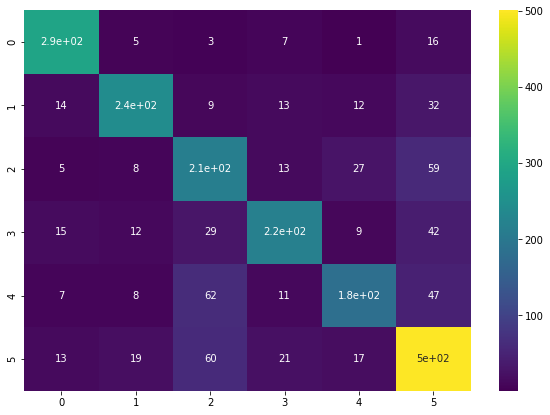

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(data_test['label'],y_predicted),annot=True,cmap='viridis')
plt.show()

# 5. Prediction on custom text

In [ ]:
texts = input(str('input the text'))

x_val = tokenizer(
    text=texts,
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding='max_length', 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True) 
validation = model.predict({'input_ids':x_val['input_ids'],'attention_mask':x_val['attention_mask']})*100
validation

input the textThe time I knocked a deer down - the sight of the animal's injuries and helplessness.  The realization that the animal was so badly hurt that it had to be put down, and when the animal screamed at the moment of death.
1/1 [==============================] - 1s 607ms/step


array([[ 6.3110642, 54.65519  , 58.01241  , 86.62576  , 95.07942  ,
        80.78279  ]], dtype=float32)

In [ ]:
for key , value in zip(encoded_dict.keys(),validation[0]):
    print(key,value)

anger 21.19654
fear 97.27436
joy 35.059303
love 30.612383
sadness 11.483111
surprise 58.521206


# Thanking you